# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1tYKk1hU4kSdO-gUpRaYCw5x6CaPTgz7c/view?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

import os
import numpy as np
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-4-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
print("Minimum Value")
print(subdf.min())

Minimum Value
age        17
yredu       1
capgain     0
caploss     0
workhr      1
dtype: int64


In [ ]:
print("Maximum Value")
print(subdf.max())

Maximum Value
age           90
yredu         16
capgain    99999
caploss     4356
workhr        99
dtype: int64


In [ ]:
print("Average Value")
print(subdf.mean())

Average Value
age          38.581647
yredu        10.080679
capgain    1077.648844
caploss      87.303830
workhr       40.437456
dtype: float64


In [ ]:
df[["age", "yredu", "capgain", "caploss", "workhr"]] = (subdf- subdf.min()) / (subdf.max() - subdf.min())
print("Normalization")
print(df[["age", "yredu", "capgain", "caploss", "workhr"]][:3])

Normalization
        age     yredu  capgain  caploss    workhr
0  0.301370  0.800000  0.02174      0.0  0.397959
1  0.452055  0.800000  0.00000      0.0  0.122449
2  0.287671  0.533333  0.00000      0.0  0.397959


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
#print(sum(df["sex"] == " Female"))
print("Female Percentage: {:.4f}%".format(sum(df["sex"] == " Female")/32561 *100))

Female Percentage: 33.0795%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print("{} Records with Missing Features".format(len(df_with_missing)))
print("Removed Records Percentage: {:.4f}%".format(len(df_with_missing) / (len(df)) * 100))

1843 Records with Missing Features
Removed Records Percentage: 5.6601%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
print(set(df_not_missing["work"]))

{' Federal-gov', ' State-gov', ' Without-pay', ' Local-gov', ' Self-emp-inc', ' Private', ' Self-emp-not-inc'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print("{} columns(features) are in the dataframe data.".format(len(data.columns)))

57 columns(features) are in the dataframe data.


There are 57 columns in the dataframe data, generated from the code data = pd.get_dummies(df_not_missing). All categorical (not number type) value are converted into the One-Hot encoding, which means all possible unique category in a column is turned into multiple columns that has the title encoding as {original_col}_{unique value}. Also,  the values for these new columns are either 0 or 1.

For example, the column of work was transferred to 7 columns of work_ Federal-gov, work_ State-gov, etc. The value is 1 where the string value in the original data set matches the string in the column name, and 0 otherwise.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

print(cat_index)
print(cat_values)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [ ]:
# test the provided examples above
print("test1 : get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), \"work\")")
print("return: {}".format(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")))

print("test2 : get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), \"work\")")
print("return: {}".format(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")))

test1 : get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
return: State-gov
test2 : get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
return: Private


### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)

train_index = int(datanp.shape[0] * 0.7)
val_index = int(datanp.shape[0] * 0.85)

train_set = datanp[:train_index]
val_set = datanp[train_index:val_index]
test_set = datanp[val_index:]

print("length of train Set: {} " .format(str(train_set.shape[0])))
print("length of Val Set: {} " .format(str(val_set.shape[0])))
print("length of test Set: {} " .format(str(test_set.shape[0])))

length of train Set: 21502 
length of Val Set: 4608 
length of test Set: 4608 


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 35), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(35, 25),
            nn.ReLU(),
            nn.Linear(25, 15)
        )
        self.decoder = nn.Sequential(
            nn.Linear(15, 25), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(25, 35),
            nn.ReLU(),
            nn.Linear(35, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The input values are all within the range of 0 to 1. As such, since the decoder needs to reconstruct the inputs, the output of the decoder should also be within the range of 0 to 1. The sigmoid activation guarantees that the final output of the decoder will be in that range.

In short, all inputs are bounded in the range of 0 to 1; by having the sigmoid function, the output will also have the same range as the input.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []
    for epoch in range(num_epochs):
        total_num = 0
        train_loss = 0
        for data in train_loader:
            total_num += 1
            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss

        # save the info
        iters.append(epoch)
        losses.append(float(train_loss)/total_num)
        train_acc.append(get_accuracy(model, train_loader)) # compute train accuracy
        val_acc.append(get_accuracy(model, valid_loader))  # compute valid accuracy
        print("epoch={}, train_accuracy={}, val_accuracy={}".format(epoch, train_acc[-1], val_acc[-1]))


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch=0, train_accuracy=0.5527857873686168, val_accuracy=0.5551938657407407
epoch=1, train_accuracy=0.5883561219111401, val_accuracy=0.5866247106481481
epoch=2, train_accuracy=0.5849610888909559, val_accuracy=0.5830439814814815
epoch=3, train_accuracy=0.5925727839270766, val_accuracy=0.591796875
epoch=4, train_accuracy=0.5971382507053608, val_accuracy=0.5932074652777778
epoch=5, train_accuracy=0.6127026943230087, val_accuracy=0.6107855902777778
epoch=6, train_accuracy=0.6152683471304995, val_accuracy=0.6130280671296297
epoch=7, train_accuracy=0.6166635661798903, val_accuracy=0.6123770254629629
epoch=8, train_accuracy=0.6192834775059685, val_accuracy=0.6166449652777778
epoch=9, train_accuracy=0.6205934331690075, val_accuracy=0.6182364004629629


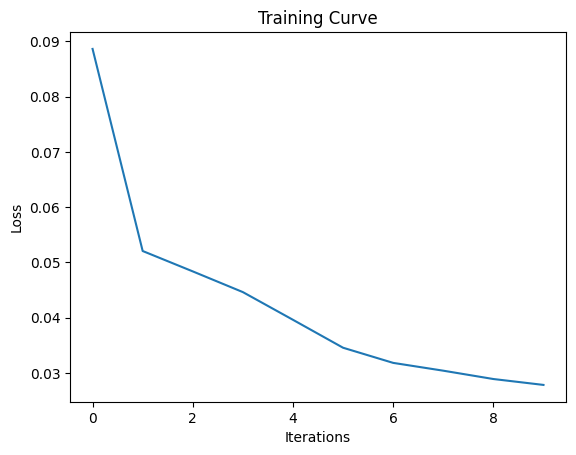

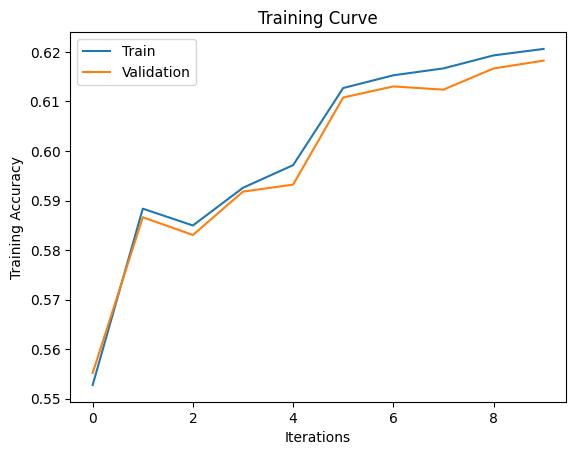

Final Training Accuracy: 0.6205934331690075
Final Validation Accuracy: 0.6182364004629629


In [ ]:
model = AutoEncoder()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)
train(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

In [ ]:
def train_without_curve(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []
    for epoch in range(num_epochs):
        total_num = 0
        train_loss = 0
        for data in train_loader:
            total_num += 1
            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss

        # save the info
        iters.append(epoch)
        losses.append(float(train_loss)/total_num)
        train_acc.append(get_accuracy(model, train_loader)) # compute train accuracy
        val_acc.append(get_accuracy(model, valid_loader))  # compute valid accuracy
        #print("epoch={}, train_accuracy={}, val_accuracy={}".format(epoch, train_acc[-1], val_acc[-1]))

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Model 1: I increased the batch size to reduce noise. The curve is smoother but does not converge for both train and val accuracy. I think it is due to the batch size being too large, which leads to less frequent updates to the model parameters. The training and validation accuracy is similar to that of part(c). Overall, it is not a good model.

In [ ]:
model = AutoEncoder()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)
train_without_curve(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)


Final Training Accuracy: 0.615865190834961
Final Validation Accuracy: 0.6135344328703703


Model 2: When using larger batch sizes, we should increase the learning rate as well. With a more stable gradient estimate, the model can handle larger updates, which can help with convergence. If the learning rate remains low while using a larger batch size like the first model, the updates may be too small to effectively make use of the information produced by the larger batch. So I increased the learning rate to 0.002.

The curve is now converging successfully and it is converging faster than the part (c) model. However, both training and validation accuracy are not better than part(c). Overall, it is not a good model.

In [ ]:
model = AutoEncoder()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)
train_without_curve(model, train_loader, val_loader, num_epochs=10, learning_rate=0.002)

Final Training Accuracy: 0.5840076892072056
Final Validation Accuracy: 0.5844184027777778


In [ ]:
class AutoEncoder_alt(nn.Module):
    def __init__(self):
        super(AutoEncoder_alt, self).__init__()
        self.name = "AutoEncoder_alt"
        self.encoder = nn.Sequential(
            nn.Linear(57, 45), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(45, 35),
            nn.ReLU(),
            nn.Linear(35, 25),
            nn.ReLU(),
            nn.Linear(25, 15)
        )
        self.decoder = nn.Sequential(
            nn.Linear(15, 25), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(25, 35),
            nn.ReLU(),
            nn.Linear(35, 45),
            nn.ReLU(),
            nn.Linear(45, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Model 3: I increased the complexity (number of hidden layers) in AutoEncoder. I want to see if the extra layer can help learn more features, which is important for tasks involving high-dimensional data (I think 57 features should be considered as high). Also, since the model 2 method of increasing both batch and learning rates seems to make convergence faster, I increased both in this model as well.

The resulting curve is not as smooth as models one and two but it is performing better and we have more small loss iterations than before. Also, this model is converging much slower than model 2 and has more noticeable noises.

In [ ]:
model = AutoEncoder_alt()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=True)
train_without_curve(model, train_loader, val_loader, num_epochs=30, learning_rate=0.005)

Final Training Accuracy: 0.6170123709422379
Final Validation Accuracy: 0.6125578703703703


Model 4: The universal approximation theorem states that a feedforward neural network with a single hidden layer containing a finite number of neurons can approximate any continuous function. So, we can reason that even a single hidden layer can model complex relationships in the data, given enough neurons.

So, instead of like model 3, we add an extra hidden layer, in model 4 we still have one hidden layer but made some adjustments to the neurons (for example, made the output size closer to the suggested 11).

I made some other more drastic changes to the neuron sizes not presented here but these models either do similar to this one or much worse.

The output curve is better than model 3 because it converges very quickly and at a higher accuracy than models 1 and 2. It also has less noise than model 3.

In [ ]:
class AutoEncoder_alt(nn.Module):
    def __init__(self):
        super(AutoEncoder_alt, self).__init__()
        self.name = "AutoEncoder_alt"
        self.encoder = nn.Sequential(
            nn.Linear(57, 36), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(36, 24),
            nn.ReLU(),
            nn.Linear(24, 13)
        )
        self.decoder = nn.Sequential(
            nn.Linear(13, 24), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(24, 36),
            nn.ReLU(),
            nn.Linear(36, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model4 = AutoEncoder_alt()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)
train_without_curve(model4, train_loader, val_loader, num_epochs=30, learning_rate=0.005)

Final Training Accuracy: 0.6469398195516696
Final Validation Accuracy: 0.6426504629629629


my best model out of the four is model 4

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_loader4 = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True)
test_accuracy = get_accuracy(model4, test_loader4)
print("Final Test Accuracy of model 4: {} %".format(test_accuracy * 100))

Final Test Accuracy of model 4: 64.24696180555556 %


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
most_common_val = {}
for col in df_not_missing.columns:
  # get the most common value for each col
  most_common_val[col] = df_not_missing[col].value_counts().idxmax()

accuracy = sum(df_not_missing['marriage'] == most_common_val['marriage'])/len(df_not_missing) *100
print("baseline model of missing 'marriage' test accuracy is: {}%".format(accuracy))

baseline model of missing 'marriage' test accuracy is: 46.67947131974738%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The test accuracy of the model in part(a) is 64.25% and the test accuracy of baseline model is 46.68%.

Comparing to baseline model, autoencoder has a much higher test accuracy which makes sense since it is making predictions based on the embedding features about all the information constructed by our autoencoders (it should be better than just using the most common value as the prediction).

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
get_features(test_set[0])

{'work': 'Private',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'edu': 'Bachelors',
 'relationship': 'Not-in-family',
 'sex': 'Male'}

I believe it is reasonable because the occupation and work of a person could reveal some information on their education backaround. For this example, the person has an occupation as Prof-specialty; we can therefore deduct the education level to be at least college-grad (profschool-grad).

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
# use code from get_accuracy()
for item in test_loader4: # minibatches
  inp = item.detach().numpy()
  out = model(zero_out_feature(item.clone(), "edu")).detach().numpy()
  for i in range(out.shape[0]): # record in minibatch
    print(get_feature(out[i], "edu"))
    break
  break

Bachelors


My model's prediction of this person's education level is correct.

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
print(most_common_val['edu'])

 HS-grad
